In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score as r2 
from sklearn.metrics import mean_absolute_percentage_error as mape
import shap, datetime, warnings
warnings.filterwarnings('ignore')

In [65]:
# Open the pickle file
df = pickle.load(open('../../data/processed/merged_data_finance.pkl', 'rb'))
predictions = pd.read_pickle('../../output/predictions_overall.pkl')

In [66]:
predictions.rename(columns={'Predicted (LightGBM) (all_tuned_retrained)': 'Predicted (Best Model)'}, inplace=True)
predictions

,date,ticker,Actual,hour_of_day_10,hour_of_day_11,hour_of_day_12,hour_of_day_13,hour_of_day_14,hour_of_day_15,hour_of_day_9,...,Predicted (NeuralNet) (all),Predicted (LightGBM) (time_only),Predicted (LightGBM) (sentiment_only),Predicted (LightGBM) (self_finance_only),Predicted (LightGBM) (finance_only),Predicted (LightGBM) (finance_time),Predicted (LightGBM) (all),Predicted (LightGBM) (all_tuned),Predicted (Best Model),Predicted Baseline
0,2023-12-04 12:45:00,AAL,1293240,0,0,1,0,0,0,0,...,1.062676e+06,2.166145e+05,853039.208070,1.466402e+06,1.467144e+06,1.444167e+06,1.398818e+06,1.273039e+06,1.385569e+06,778534.8
1,2023-12-04 12:45:00,ALGT,1447,0,0,1,0,0,0,0,...,9.692740e+03,2.166145e+05,117560.899842,3.084344e+03,2.405521e+03,5.587949e+03,3.406106e+03,1.775199e+03,3.620900e+03,3024.0
2,2023-12-04 12:45:00,ALK,587333,0,0,1,0,0,0,0,...,1.615639e+05,2.166145e+05,657044.943388,3.758347e+05,4.132884e+05,3.735391e+05,3.653477e+05,3.965052e+05,3.878293e+05,27429.2
3,2023-12-04 12:45:00,DAL,94989,0,0,1,0,0,0,0,...,1.294410e+05,2.166145e+05,276890.669042,1.747686e+05,1.862419e+05,1.748006e+05,1.693648e+05,1.612089e+05,1.758026e+05,142879.8
4,2023-12-04 12:45:00,JBLU,273608,0,0,1,0,0,0,0,...,3.706713e+05,2.166145e+05,830606.119024,5.119678e+05,5.256118e+05,4.896124e+05,4.796478e+05,4.580689e+05,4.958197e+05,372734.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67553,2025-05-30 15:45:00,ALK,440444,0,0,0,0,0,1,0,...,7.893551e+05,1.063072e+06,205925.448478,3.283563e+05,3.981022e+05,5.539017e+05,5.802983e+05,5.299487e+05,4.925179e+05,353491.8
67554,2025-05-30 15:45:00,DAL,1245698,0,0,0,0,0,1,0,...,9.146906e+05,1.063072e+06,376416.982429,1.007004e+06,1.023123e+06,1.061786e+06,1.058074e+06,1.242038e+06,1.076072e+06,1506096.4
67555,2025-05-30 15:45:00,JBLU,8400782,0,0,0,0,0,1,0,...,4.472642e+06,1.063072e+06,285688.984920,3.415540e+06,3.235173e+06,3.590649e+06,3.451630e+06,3.598861e+06,3.577430e+06,3093992.0
67556,2025-05-30 15:45:00,LUV,2026886,0,0,0,0,0,1,0,...,2.007167e+06,1.063072e+06,316754.581946,1.256809e+06,1.268855e+06,1.217692e+06,1.229052e+06,1.449506e+06,1.282050e+06,1424504.4


In [67]:
predict_cols = [i for i in predictions.columns if 'Predicted' in i]
price = df[['date', 'ticker', 'Last']].copy()
predictions = pd.merge(predictions, price, on=['date', 'ticker'], how='left')
for col in predict_cols:
    predictions[col] = np.where(predictions[col] < 0, 0, predictions[col])

In [68]:
vwap_data = predictions[['date','ticker','Actual','Last']+predict_cols].copy()
vwap_data['$ Volume'] = vwap_data['Actual'] * vwap_data['Last']
vwap_data['day'] = vwap_data['date'].dt.date
vwap_data.drop(columns=['date'], inplace=True)

In [69]:
vwap_data_agg = vwap_data.groupby(['day', 'ticker']).sum().reset_index()
vwap_data_agg = vwap_data_agg[['day', 'ticker', 'Actual']+predict_cols]

for col in ['Actual']+predict_cols:
    vwap_data_agg.rename(columns={col: f'Tot. {col}'}, inplace=True)

vwap_data = pd.merge(vwap_data, vwap_data_agg, on=['day', 'ticker'], how='left')

vwap_data['weight (Actual)']   = vwap_data['Actual'] / vwap_data['Tot. Actual']
vwap_data['weighted price (Actual)']   = vwap_data['Last'] * vwap_data['weight (Actual)']

In [70]:
for col in ['Actual']+predict_cols:
    n = col.replace('Predicted ', '')
    vwap_data[f'weight {n}'] = vwap_data[col] / vwap_data[f'Tot. {col}']
    vwap_data[f'weighted price {n}'] = vwap_data['Last'] * vwap_data[f'weight {n}']

In [71]:
vwap_data = vwap_data[['day', 'ticker'] + [f'weighted price {col.replace('Predicted ', '')}' for col in ['Actual']+predict_cols]]
vwap_data = vwap_data.groupby(['day', 'ticker']).sum().reset_index()
vwap_data.rename(columns={
    'weighted price Actual': 'VWAP',
    'weighted price (Baseline)': 'VWAP (Baseline)',
    'weighted price (Best)': 'VWAP (Best)'
}, inplace=True)
vwap_data.rename(columns={col: col.replace('weighted price', 'VWAP') for col in vwap_data.columns if 'weighted price' in col}, inplace=True)
vwap_data

,day,ticker,VWAP,VWAP (OLS) (time_only),VWAP (OLS) (sentiment_only),VWAP (OLS) (self_finance_only),VWAP (OLS) (finance_only),VWAP (OLS) (finance_time),VWAP (OLS) (all),VWAP (LASSO) (time_only),...,VWAP (NeuralNet) (all),VWAP (LightGBM) (time_only),VWAP (LightGBM) (sentiment_only),VWAP (LightGBM) (self_finance_only),VWAP (LightGBM) (finance_only),VWAP (LightGBM) (finance_time),VWAP (LightGBM) (all),VWAP (LightGBM) (all_tuned),VWAP (Best Model),VWAP Baseline
0,2023-12-04,AAL,13.314963,13.310975,13.304371,13.314116,13.314385,13.314358,13.314229,13.310974,...,13.313332,13.312443,13.305784,13.312325,13.312695,13.312320,13.312484,13.311481,13.312267,13.313857
1,2023-12-04,ALGT,73.524040,73.506222,73.384567,73.695168,73.584303,73.683098,73.618251,73.506212,...,73.592137,73.498449,73.416334,73.575058,73.610382,73.621075,73.596646,73.604279,73.596081,73.585242
2,2023-12-04,ALK,33.932099,33.897968,33.858890,33.877229,33.888734,33.898110,33.900620,33.897964,...,33.938308,33.901651,33.854000,33.882026,33.885615,33.888044,33.887122,33.881286,33.889498,33.941709
3,2023-12-04,DAL,38.179126,38.182690,38.194057,38.178472,38.179378,38.180247,38.182296,38.182692,...,38.183323,38.185616,38.199396,38.183349,38.180276,38.180565,38.180194,38.180170,38.181278,38.176791
4,2023-12-04,JBLU,4.844858,4.845730,4.843000,4.845547,4.845676,4.846087,4.844485,4.845730,...,4.846558,4.846493,4.846102,4.845902,4.845409,4.846531,4.846468,4.846783,4.846691,4.847222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2606,2025-05-30,ALK,51.096143,51.157961,51.149365,51.154790,51.139737,51.128398,51.116423,51.157961,...,51.071139,51.161065,51.150887,51.124964,51.119594,51.102550,51.101621,51.100836,51.110043,51.107652
2607,2025-05-30,DAL,48.341269,48.284468,48.358658,48.325723,48.319122,48.322465,48.328029,48.284468,...,48.336119,48.287281,48.294285,48.321147,48.322295,48.326740,48.327390,48.333583,48.327450,48.302733
2608,2025-05-30,JBLU,5.120709,5.126008,5.139084,5.131914,5.132357,5.131830,5.131541,5.126008,...,5.119989,5.125079,5.138282,5.130325,5.129456,5.124364,5.125178,5.125447,5.126554,5.130313
2609,2025-05-30,LUV,33.380001,33.367039,33.365455,33.374978,33.374843,33.373872,33.375157,33.367039,...,33.371296,33.368846,33.369937,33.371805,33.369861,33.369034,33.370589,33.369179,33.370652,33.371351


In [72]:
cols = [i for i in vwap_data.columns if 'VWAP' in i and i != 'VWAP']

for col in cols:
    n = col.replace('VWAP ', 'VWAP Error ')
    vwap_data[n] = np.abs(vwap_data['VWAP'] - vwap_data[col]) / vwap_data['VWAP'] * 100 * 100  # basis points
vwap_data
#vwap_data['VWAP Error (Baseline)'] = np.abs(vwap_data['VWAP'] - vwap_data['VWAP (Baseline)']) / vwap_data['VWAP'] * 100 * 100 # basis points
#vwap_data['VWAP Error (Best)']     = np.abs(vwap_data['VWAP'] - vwap_data['VWAP (Best)'])     / vwap_data['VWAP'] * 100 * 100 # basis points

,day,ticker,VWAP,VWAP (OLS) (time_only),VWAP (OLS) (sentiment_only),VWAP (OLS) (self_finance_only),VWAP (OLS) (finance_only),VWAP (OLS) (finance_time),VWAP (OLS) (all),VWAP (LASSO) (time_only),...,VWAP Error (NeuralNet) (all),VWAP Error (LightGBM) (time_only),VWAP Error (LightGBM) (sentiment_only),VWAP Error (LightGBM) (self_finance_only),VWAP Error (LightGBM) (finance_only),VWAP Error (LightGBM) (finance_time),VWAP Error (LightGBM) (all),VWAP Error (LightGBM) (all_tuned),VWAP Error (Best Model),VWAP Error Baseline
0,2023-12-04,AAL,13.314963,13.310975,13.304371,13.314116,13.314385,13.314358,13.314229,13.310974,...,1.225076,1.893120,6.893839,1.981518,1.703382,1.984965,1.861708,2.615619,2.024732,0.830689
1,2023-12-04,ALGT,73.524040,73.506222,73.384567,73.695168,73.584303,73.683098,73.618251,73.506212,...,9.261817,3.480636,14.649097,6.938945,11.743397,13.197698,9.875115,10.913365,9.798247,8.324118
2,2023-12-04,ALK,33.932099,33.897968,33.858890,33.877229,33.888734,33.898110,33.900620,33.897964,...,1.829759,8.973230,23.016112,14.756750,13.699029,12.983298,13.254973,14.974919,12.554718,2.832093
3,2023-12-04,DAL,38.179126,38.182690,38.194057,38.178472,38.179378,38.180247,38.182296,38.182692,...,1.099244,1.699753,5.309154,1.105912,0.301086,0.376836,0.279672,0.273224,0.563522,0.611823
4,2023-12-04,JBLU,4.844858,4.845730,4.843000,4.845547,4.845676,4.846087,4.844485,4.845730,...,3.509056,3.375156,2.567020,2.155603,1.136854,3.453248,3.322744,3.974475,3.783984,4.880358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2606,2025-05-30,ALK,51.096143,51.157961,51.149365,51.154790,51.139737,51.128398,51.116423,51.157961,...,4.893547,12.705745,10.713836,5.640438,4.589546,1.253879,1.072168,0.918416,2.720270,2.252396
2607,2025-05-30,DAL,48.341269,48.284468,48.358658,48.325723,48.319122,48.322465,48.328029,48.284468,...,1.065376,11.168178,9.719255,4.162521,3.925128,3.005605,2.871069,1.590029,2.858772,7.971640
2608,2025-05-30,JBLU,5.120709,5.126008,5.139084,5.131914,5.132357,5.131830,5.131541,5.126008,...,1.405944,8.534981,34.317555,18.778671,17.082309,7.137968,8.727735,9.254053,11.415948,18.756347
2609,2025-05-30,LUV,33.380001,33.367039,33.365455,33.374978,33.374843,33.373872,33.375157,33.367039,...,2.607603,3.341630,3.014931,2.455120,3.037473,3.285457,2.819557,3.241855,2.800541,2.591211


In [73]:
vwap_data = vwap_data[['ticker'] + [i for i in vwap_data.columns if 'VWAP Error' in i]].groupby('ticker').mean()
vwap_data['Improvement'] = ((vwap_data['VWAP Error (Best Model)'] / vwap_data['VWAP Error Baseline']) - 1) * 100
vwap_data

,VWAP Error (OLS) (time_only),VWAP Error (OLS) (sentiment_only),VWAP Error (OLS) (self_finance_only),VWAP Error (OLS) (finance_only),VWAP Error (OLS) (finance_time),VWAP Error (OLS) (all),VWAP Error (LASSO) (time_only),VWAP Error (LASSO) (sentiment_only),VWAP Error (LASSO) (self_finance_only),VWAP Error (LASSO) (finance_only),...,VWAP Error (LightGBM) (time_only),VWAP Error (LightGBM) (sentiment_only),VWAP Error (LightGBM) (self_finance_only),VWAP Error (LightGBM) (finance_only),VWAP Error (LightGBM) (finance_time),VWAP Error (LightGBM) (all),VWAP Error (LightGBM) (all_tuned),VWAP Error (Best Model),VWAP Error Baseline,Improvement
ticker,,,,,,,,,,,,,,,,,,,,,
AAL,13.829784,16.393584,7.782596,7.831253,7.824317,7.929690,13.829574,15.951877,7.786274,7.832115,...,13.972612,14.605663,7.522683,7.516978,7.598911,7.592335,7.144917,7.374818,11.084991,-33.470238
ALGT,48.155369,153.849941,31.217820,26.908685,24.991196,23.490614,48.155074,153.408844,30.604768,27.393261,...,47.700255,45.154700,18.744137,19.545245,18.141481,17.126219,19.341065,16.318264,18.348317,-11.063976
ALK,21.706786,77.024618,10.269565,11.074451,11.869112,15.240505,21.706521,50.697062,10.239553,10.995787,...,21.378116,20.802806,8.453494,8.422977,7.710094,8.142662,9.080183,8.070972,11.170914,-27.750123
DAL,12.969979,44.390417,7.698563,7.580679,6.892266,7.488268,12.969788,17.508608,7.717495,7.519733,...,12.683847,15.459657,6.432812,6.380245,6.094043,6.013934,5.926529,5.997430,11.215983,-46.527828
JBLU,25.659873,82.918218,14.580229,14.431024,14.242042,14.567279,25.659432,82.829430,14.586158,14.455411,...,25.737150,24.673745,13.382287,13.582906,13.846278,13.368655,12.528440,12.481346,18.122388,-31.127473
LUV,15.032851,70.331333,7.706558,7.472182,7.104141,7.338526,15.032582,70.226229,7.713825,7.480352,...,14.675597,14.531480,6.981399,7.027069,7.046319,6.723313,6.484527,6.490618,9.894660,-34.402818
UAL,20.672536,52.676329,11.283694,10.822574,10.300693,11.292292,20.672421,51.676875,11.300546,10.881797,...,20.578879,22.488729,10.485134,10.357319,10.088371,9.946038,10.148793,9.826889,15.544927,-36.783950


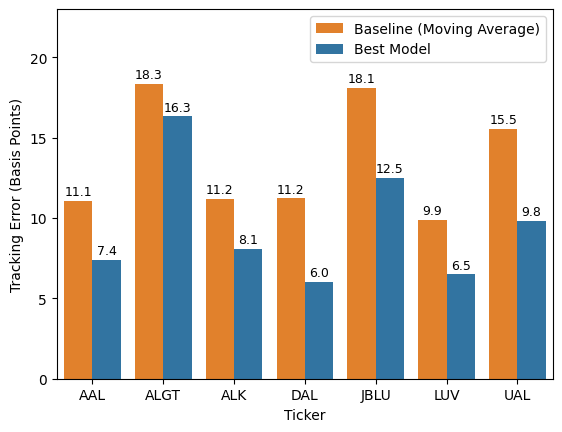

In [79]:
plot_data = vwap_data[['VWAP Error Baseline', 'VWAP Error (Best Model)']].copy()
plot_data = plot_data.stack().reset_index()
plot_data['level_1'] = plot_data['level_1'].str.replace('VWAP Error Baseline','Baseline (Moving Average)').replace('VWAP Error (Best Model)','Best Model')

# Swap the colors of the bars by specifying the palette order
palette = {
    'Best Model': sns.color_palette()[0],                 # Use the first color for Best Model
    'Baseline (Moving Average)': sns.color_palette()[1]  # Use the second color for Baseline
}
ax = sns.barplot(data=plot_data, x='ticker', y=0, hue='level_1', palette=palette)
plt.ylim(0,23)
plt.legend(title='')
plt.xlabel('Ticker')
plt.ylabel('Tracking Error (Basis Points)')

# Add data labels
for p in ax.patches:
    
    height = p.get_height()
    if not np.isnan(height) and height > 0:
        ax.annotate(f'{height:.1f}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom',
                    fontsize=9, color='black',
                    xytext=(0, 2),
                    textcoords='offset points')

plt.savefig('../../output/vwap_compare.pdf')

In [ ]:
plot_data = vwap_data.describe().T
plot_data = plot_data.reset_index()
plot_data = plot_data[['index', 'mean']]
plot_data = plot_data[plot_data['index']!='Improvement']
plot_data.sort_values(by='mean', ascending=True, inplace=True)

plot_data['index'] = plot_data['index'].str.replace('VWAP Error ', '')
plot_data['index'] = plot_data['index'].str.replace('(', '')
plot_data['index'] = plot_data['index'].str.replace(')', '')
plot_data['index'] = plot_data['index'].str.replace(' finance_time', ', Market + Own-Stock + Time')
plot_data['index'] = plot_data['index'].str.replace(' self_finance_only', ', Own-Stock Only')
plot_data['index'] = plot_data['index'].str.replace(' finance_only', ', Market + Own-Stock')
plot_data['index'] = plot_data['index'].str.replace(' all_tuned', ', All Features (Tuned)')
plot_data['index'] = plot_data['index'].str.replace(' all', ', All Features')
plot_data['index'] = plot_data['index'].str.replace(' time_only', ', Time Only')
plot_data['index'] = plot_data['index'].str.replace(' sentiment_only', ', Sentiment Only')
plot_data['index'] = plot_data['index'].str.replace('Best Model', 'Best Model (LightGBM, All Features, Tuned, Retrained)')
plot_data['index'] = plot_data['index'].str.replace('Baseline', 'Baseline (Moving Average)')

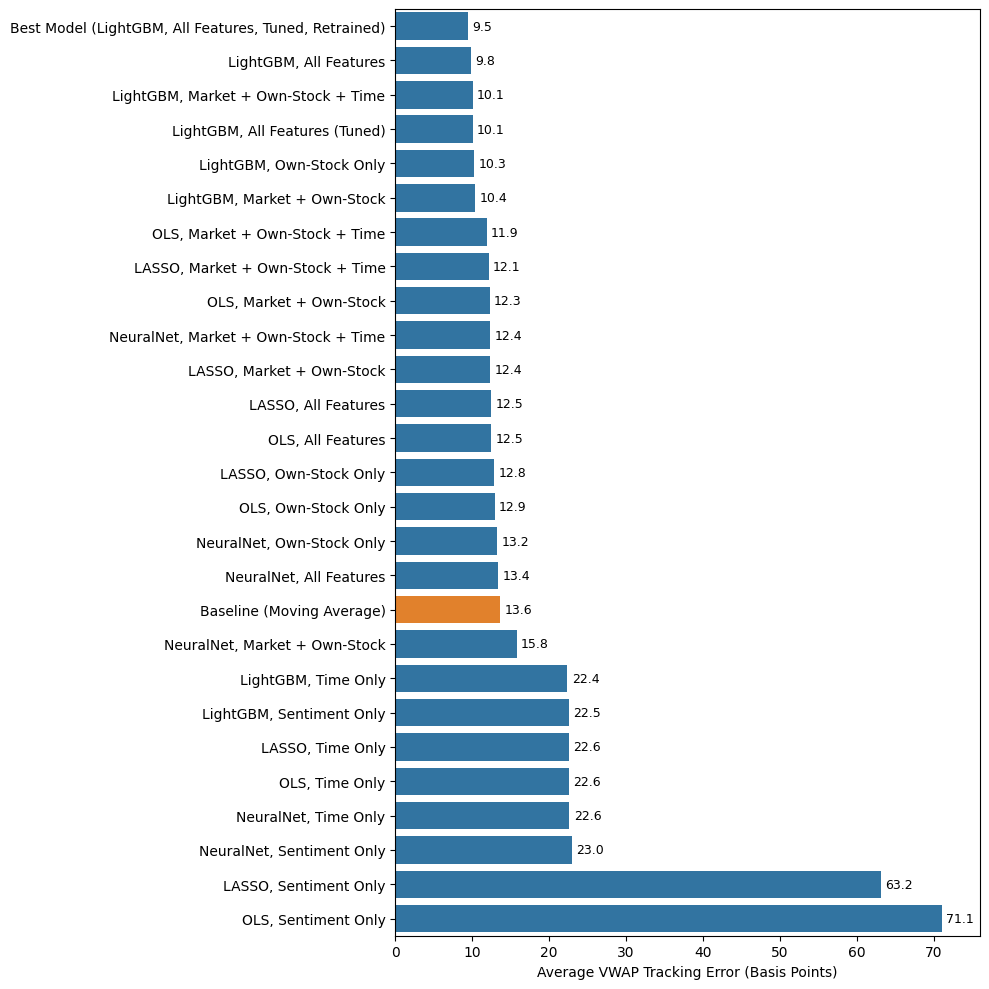

In [109]:
# Horizontal bar plot of average tracking error for all models
# Assign colors: orange for Baseline (Moving Average), blue for others
colors = np.where(plot_data['index']=='Baseline (Moving Average)', 'C1', 'C0')

plt.figure(figsize=(10, 10))
bars = sns.barplot(data=plot_data, y='index', x='mean', palette=colors)
plt.xlim(0, 76)
plt.xlabel('Average VWAP Tracking Error (Basis Points)')
plt.ylabel('')

# Add data labels
for p in plt.gca().patches:
    width = p.get_width()
    if not np.isnan(width) and width > 0:
        plt.gca().annotate(f'{width:.1f}',
                           (width, p.get_y() + p.get_height() / 2.),
                           ha='left', va='center',
                           fontsize=9, color='black',
                           xytext=(3, 0),
                           textcoords='offset points')

plt.tight_layout()
plt.savefig('../../output/vwap_compare_all_models.pdf')

In [ ]:
# VWAP error over time

In [151]:
portfolio

,day,ticker,Actual,Last,Predicted Baseline,Predicted (LightGBM) (all_tuned_retrained),$ Volume,1% of Turnover
0,2023-12-04,AAL,17598756,172.958405,14652707.2,1.838870e+07,2.343268e+08,2.343268e+06
1,2023-12-04,ALGT,87461,954.496094,87254.6,9.866597e+04,6.430486e+06,6.430486e+04
2,2023-12-04,ALK,7575095,440.104706,871959.8,5.920561e+06,2.570389e+08,2.570389e+06
3,2023-12-04,DAL,2231543,496.627808,3277999.2,2.793705e+06,8.519836e+07,8.519836e+05
4,2023-12-04,JBLU,6317349,63.009399,7136817.8,7.980021e+06,3.060666e+07,3.060666e+05
...,...,...,...,...,...,...,...,...
2606,2025-05-30,ALK,1654853,1329.640015,1816027.8,1.739838e+06,8.455661e+07,8.455661e+05
2607,2025-05-30,DAL,5486818,1255.502441,6702640.4,5.501810e+06,2.652397e+08,2.652397e+06
2608,2025-05-30,JBLU,30301587,133.649506,25635536.6,2.720048e+07,1.551656e+08,1.551656e+06
2609,2025-05-30,LUV,7274456,867.630005,8878496.8,6.928393e+06,2.428213e+08,2.428213e+06
